In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import odeint
import networkx as nx

from scipy import stats

import pybel as pb
import json
import time
import csv

import torch
import pyro

from bel2scm import graph_node as cn
from bel2scm import gen_test_data as td
from bel2scm import causal_graph as cg

pyro.set_rng_seed(101)
torch.set_default_tensor_type(torch.DoubleTensor)

In [9]:
tot_data = td.data_gen(10000)

# Unit Tests

In [10]:
# Unit Test in icream graph

str_list = ['temp =| cloudy','cloudy => rainy','temp => icream','rainy =| icream']
type_dict = {}
type_dict['temp'] = 'continuous'
type_dict['cloudy'] = 'continuous'
type_dict['rainy'] = 'continuous'
type_dict['icream'] = 'continuous'
graph_test = cg.str_graph(str_list=str_list,graph_type='SCM',type_dict=type_dict)
graph_test.add_confound([['icream','cloudy']])

print(graph_test.d_sep(['icream'],['cloudy'],['rainy','temp']))
#Ans: False
print()
print(graph_test.id_alg(['icream'],['cloudy']))
#Ans: P_{cloudy}(icream) = sum_{rainy} P(rainy|cloudy) sum_{cloudy}′P(icream|cloudy',rainy)P(cloudy')
print()

print(graph_test.idc_alg(['icream'],['cloudy'],['temp']))
#Ans: P_{cloudy}(icream|temp) = [sum_{rainy} P(rainy|cloudy,temp) sum_{cloudy'} P(icream|cloudy',rainy,temp)P(cloudy'|temp)]  
# /[sum_{rainy,icream} P(rainy|cloudy,temp) sum_{cloudy'}P(icream|cloudy',rainy,temp)P(cloudy'|temp)]

The causal graph is a acyclic
False

[sum_{temp,rainy} [sum_{} [sum_{cloudy,rainy,icream} P(temp,cloudy,rainy,icream)]][sum_{}P(rainy|cloudy)][sum_{} [sum_{cloudy} P(icream|cloudy,temp,rainy)P(cloudy|temp)]]]

[[sum_{rainy} [sum_{}P(rainy|cloudy)][sum_{} [sum_{cloudy} P(icream|cloudy,temp,rainy)P(cloudy|temp)]]]]/[ sum_{icream}[sum_{rainy} [sum_{}P(rainy|cloudy)][sum_{} [sum_{cloudy} P(icream|cloudy,temp,rainy)P(cloudy|temp)]]]]


In [11]:
# Unit Test in XYZ Graph

str_list = ['X =| W','D => Z','W => Y','Z =| Y','V =| Z']
type_dict = {}
type_dict['X'] = 'continuous'
type_dict['W'] = 'continuous'
type_dict['D'] = 'continuous'
type_dict['Z'] = 'continuous'
type_dict['Y'] = 'continuous'
type_dict['V'] = 'continuous'

graph_test = cg.str_graph(str_list=str_list,graph_type='SCM',type_dict=type_dict)
graph_test.add_confound([['X','Y']])

print(graph_test.d_sep(['D'], ['Z'],['Y']))
# Ans: True
print()
print(graph_test.id_alg(['Y'],['X']))
# Ans: P_X(Y) = sum_W P(W|X) sum_X' P(Y|X',W)P(X')
print()
print(graph_test.idc_alg(['Y'],['X'],['W']))
# Ans: P_X(Y|W) = [sum_{D,V,Z} P(Z|D,V) P(V) P(D) sum_X' P(Y|D,V,W,X′,Z) P(X'|D,V,Z)]
#/[sum_{D,V,Z,Y} P(Z|D,V) P(V) P(D) sum_x' P(Y|D,V,W,X′,Z) P(X'|D,V,Z)]
print()
print(graph_test.idc_alg(['Y'],['X'],['V']))
# Ans: P_X(Y|V) = [sum_{W,D,Z} P(W|X)P(D) P(Z|D,V)[sum_{X} P(X')P(Y|X',V,W,D,Z)]]
#/[sum_{W,D,Z,Y} P(W|X)P(D) P(Z|D,V)[sum_{X'} P(X)P(Y|X',V,W,D,Z)]]

# Note that the code doesn't automatically put in the ' for summation/dummy variables - you have to
# infer this from the nested brackets; summation only applies to items inside the summation sign

The causal graph is a acyclic
False

[sum_{W,D,Z,V} [sum_{}P(W|X)][sum_{} [sum_{X,W,Z,Y,V} P(X,W,D,Z,Y,V)]][sum_{}P(Z|D,V)][sum_{} [sum_{X} P(X)P(Y|X,W,D,Z,V)]][sum_{} [sum_{X,W,D,Z,Y} P(X,W,D,Z,Y,V)]]]

[[sum_{D,Z,V} [sum_{} [sum_{X,W,Z,Y,V} P(X,W,D,Z,Y,V)]][sum_{}P(Z|D,V)][sum_{} [sum_{X} P(X)P(Y|X,W,D,Z,V)]][sum_{} [sum_{X,W,D,Z,Y} P(X,W,D,Z,Y,V)]]]]/[ sum_{Y}[sum_{D,Z,V} [sum_{} [sum_{X,W,Z,Y,V} P(X,W,D,Z,Y,V)]][sum_{}P(Z|D,V)][sum_{} [sum_{X} P(X)P(Y|X,W,D,Z,V)]][sum_{} [sum_{X,W,D,Z,Y} P(X,W,D,Z,Y,V)]]]]

[[sum_{W,D,Z} [sum_{}P(W|X)][sum_{} [sum_{X,W,Z,Y,V} P(X,W,D,Z,Y,V)]][sum_{}P(Z|D,V)][sum_{} [sum_{X} P(X)P(Y|X,W,D,Z,V)]]]]/[ sum_{Y}[sum_{W,D,Z} [sum_{}P(W|X)][sum_{} [sum_{X,W,Z,Y,V} P(X,W,D,Z,Y,V)]][sum_{}P(Z|D,V)][sum_{} [sum_{X} P(X)P(Y|X,W,D,Z,V)]]]]


The causal graph is a acyclic


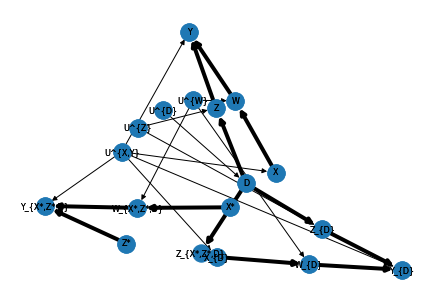

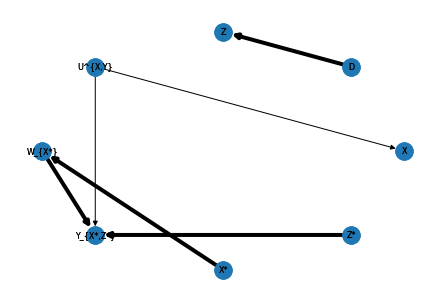

sum_{W}P(Y_{Z*,W},X)P(W_{X*})
Ans: sum_{W}P(Y_{Z*,W},X)P(W_{X*}

[sum_{W}P(Y_{Z,W},X)P(W_{X*})]/[sum_{Y}[sum_{W}P(Y_{Z,W},X)P(W_{X*})]]
Ans: [sum_{W}P(Y_{Z,W},X)P(W_{X*})]/[sum_{Y}[sum_{W}P(Y_{Z,W},X)P(W_{X*})]]


In [13]:
# Unit Test in XYZ Graph from Shpitser thesis and paper

str_list = ['X =| W','D => Z','W => Y','Z =| Y']
type_dict = {}
type_dict['X'] = 'continuous'
type_dict['W'] = 'continuous'
type_dict['D'] = 'continuous'
type_dict['Z'] = 'continuous'
type_dict['Y'] = 'continuous'

graph_test = cg.str_graph(str_list=str_list,graph_type='SCM',type_dict=type_dict)
graph_test.add_confound([['X','Y']])


do_temp = [['Y',['X*','Z*','D']],['Z',['D']]]
obs_temp = ['X','D']

do_temp2 = [['Y',['X*','Z*']]]
obs_temp2 = ['X']

do_gam = [['Y',['X*']]]
do_del = [['Z',['D']]]
obs_del = ['X','D']


g_temp,c_temp = graph_test.make_pw_graph(do_temp)
pos = nx.kamada_kawai_layout(g_temp)    
dict_temp = {}
for item in g_temp.nodes:
    dict_temp[item] = item
    
plt.figure()
nx.draw(g_temp,pos,labels=dict_temp,width=4,font_size=8)
nx.draw(c_temp,pos,labels=dict_temp,font_size=8)
plt.show()

g_temp,c_temp,gamma_temp = graph_test.make_cf_graph(do_temp,obs_temp)
pos = nx.circular_layout(g_temp)    
dict_temp = {}
for item in g_temp.nodes:
    dict_temp[item] = item
    
plt.figure()
nx.draw(g_temp,pos,labels=dict_temp,width=4,font_size=8)
nx.draw(c_temp,pos,labels=dict_temp,font_size=8)
plt.show()

print(graph_test.id_star_alg(do_temp2,obs_temp2))
print( "Ans: sum_{W}P(Y_{Z*,W},X)P(W_{X*}")
print()
print(graph_test.idc_star_alg(do_gam,do_del,[],obs_del))
print("Ans: [sum_{W}P(Y_{Z,W},X)P(W_{X*})]/[sum_{Y}[sum_{W}P(Y_{Z,W},X)P(W_{X*})]]")

Parallel Worlds Graph: <img src="shpitser_pw_graph.png">
Counterfactual Graph<img src="shpitser_cf_graph.png">